The 3 Models are:
- MobileNet
- ShuffleNet
- EfficientNet

# Device Information


In [1]:
! lsblk -io KNAME,TYPE,SIZE,MODEL #disk

zsh:1: command not found: lsblk


In [2]:
_ = ! apt install lshw #CPU
! lshw

zsh:1: command not found: lshw


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

zsh:1: command not found: nvidia-smi


# Welcome to Thoracic Abnormalities Detection with Mobile Model


Dataset: Online Dataset
<br>
<br>
Dataset Reference: https://vindr.ai/datasets/cxr

### Connect Google Drive

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

### Import All Requirements Library

In [5]:
# Full Tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Concatenate, Dropout, Conv2DTranspose, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, SeparableConv2D, Add, GlobalAveragePooling2D, Dense, Flatten, AveragePooling2D, Lambda, Rescaling
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import load_img, array_to_img, img_to_array
from tensorflow.keras import Model
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import Callback

# MISC
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
# import gdown
from datetime import datetime
import os
import glob

/Users/achmadbauravindah/miniconda3/envs/work/lib/python3.11/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [6]:
# Install Writer Excel (Untuk dokumentasi hasil pelatihan)
_ = ! pip install xlsxwriter

### Set Dataset Path

In [7]:
# Drive
EXCEL_FILENAME = "Split_NIH_ThoracicAbnotmalities_Dataset.xlsx"

In [8]:
# # Download Dataset in zip, this happen because more efficient to load npy npy images
# def download_dataset(id_url):
#     # Download Folder from Another Account Shared Folder
#     url = "https://drive.google.com/uc?id=" + id_url
#     # file_output = "Rice Leafs Dataset (Preprocessed).zip"
#     file_output = "NIH Thoracic Dataset (Filtered).zip"
#     gdown.download(url, file_output, quiet=False)

#     # _ = ! unzip "Rice Leafs Dataset (Preprocessed).zip" # unzip if data zipped
#     _ = ! unzip "NIH Thoracic Dataset (Filtered).zip" # unzip if data zipped

# id_url = "1sAwTqnYk92MWnkWvYGJsPetIvfNPH_E-"
# download_dataset(id_url)

### Initiate Labels (Abnormalities)

In [9]:
meta_data_df = pd.read_excel(EXCEL_FILENAME)
selected_labels = meta_data_df.columns[2:]
selected_labels

Index(['atelectasis', 'cardiomegaly', 'effusion', 'pneumothorax',
       'nodule/mass'],
      dtype='object')

### Show 1 Sample Image

Sample Image
Images Path: /Volumes/SanDiskLab/my-researches/datasets.thoracic-abnormalities/nih_chest_xray/images_001/images/00000117_000.png
LABEL: ['effusion']


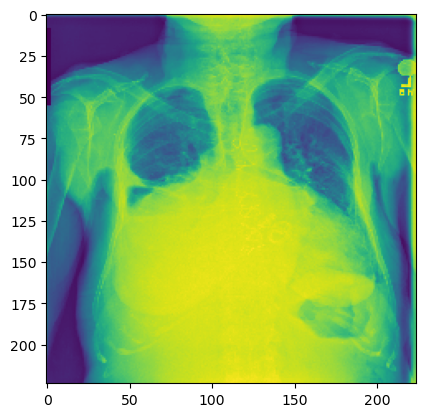

In [10]:
root_directory = "../nih_chest_xrays" # If you in Google Colab,  change the root directory
# root_directory = "/Volumes/SanDiskLab/my-researches/datasets.thoracic-abnormalities/nih_chest_xray" #Mac
# root_directory = "data
image_name = meta_data_df['Image Index'][300]
sample_image = glob.glob(f"{root_directory}/**/{image_name}", recursive=True)[0]
# Show label
row = meta_data_df.iloc[300, 2:]
labels = row[row == 1].index.tolist()

print("Sample Image")
print("Images Path: {}".format(sample_image))
fig, axes = plt.subplots(1, 1)
_ = axes.imshow(img_to_array(load_img(sample_image, target_size=(224, 224), color_mode='grayscale')).astype('uint8'))
print("LABEL:", labels)

# MobileNet Model


In [11]:
class MobileNet_Model(Model):
    def __init__(self):
        pass

    def custom_net_layers(self, inputs):
        custom_net_model = tf.keras.applications.ResNet50(
                                                        include_top=False,
                                                        weights='imagenet',
                                                        input_tensor=inputs,
                                                        input_shape=(224, 224, 3),
                                                        pooling='max')
        custom_layers = custom_net_model.output
        return custom_layers



    def call(self, inputs):
        # MobileNet Layers
        custom_net_layers = self.custom_net_layers(inputs)

        # FCL Classifier
        outputs = Dense(5, activation='sigmoid')(custom_net_layers)
        return outputs

def buildModelMobileNet():
    global MobileNet_Model
    # MODEL BUILDING
    input_shape = (224, 224, 3)
    input_layer = Input(shape=input_shape, name='input_layer')
    build_model = MobileNet_Model()
    output_layer = build_model.call(input_layer)

    # Final Model
    model = tf.keras.Model(inputs=[input_layer], outputs=[output_layer])
    learning_rate = 0.0001
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    # Compile Model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# ShuffleNet Models, I will try xception first

In [12]:
class Xception_Model(Model):
    def __init__(self):
        pass

    def custom_net_layers(self, inputs):
        custom_net_model = tf.keras.applications.Xception(
                                                        include_top=False,
                                                        weights=None,
                                                        input_tensor=inputs,
                                                        input_shape=(224, 224, 3),
                                                        pooling='avg')
        custom_layers = custom_net_model.output
        return custom_layers



    def call(self, inputs):
        # Xception Layers
        custom_net_layers = self.custom_net_layers(inputs)

        # FCL Classifier
        outputs = Dense(5, activation='sigmoid')(custom_net_layers)
        return outputs

def buildModelXception():
    global Xception_Model
    # MODEL BUILDING
    input_shape = (224, 224, 3)
    input_layer = Input(shape=input_shape, name='input_layer')
    build_model = Xception_Model()
    output_layer = build_model.call(input_layer)

    # Final Model
    model = tf.keras.Model(inputs=[input_layer], outputs=[output_layer])
    learning_rate = 0.001
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    # Compile Model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# EfficientNet Model


In [13]:
# class EfficientNetB0_Model(Model):
#     def __init__(self):
#         pass

#     def custom_net_layers(self, inputs):
#         custom_net_model = tf.keras.applications.EfficientNetB0(
#                                                         include_top=False,
#                                                         weights='imagenet',
#                                                         input_tensor=inputs,
#                                                         input_shape=(224, 224, 3),
#                                                         pooling='avg',
#                                                         classes=3)
#         custom_layers = custom_net_model.output
#         return custom_layers



#     def call(self, inputs):
#         # EfficientNetB0 Layers
#         custom_net_layers = self.custom_net_layers(inputs)

#         # FCL Classifier
#         outputs = Dense(3, activation='softmax')(custom_net_layers)
#         return outputs

# def buildModelEfficientNetB0():
#     global EfficientNetB0_Model
#     # MODEL BUILDING
#     input_shape = (224, 224, 3)
#     input_layer = Input(shape=input_shape, name='input_layer')
#     build_model = EfficientNetB0_Model()
#     output_layer = build_model.call(input_layer)

#     # Final Model
#     model = tf.keras.Model(inputs=[input_layer], outputs=[output_layer])
#     learning_rate = 0.001
#     optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

#     # Compile Model
#     model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
#     return model

### Get Images Array from Filepath in Excel

In [18]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def get_file_path_map(root_directory):
    """
    Pre-index all file paths in the root directory for faster lookups.
    """
    file_map = {}
    for root, _, files in os.walk(root_directory):
        for file in files:
            file_map[file] = os.path.join(root, file)
    return file_map

def load_and_process_image(image_path):
    """
    Load and process a single image given its path.
    """
    try:
        image_arr = img_to_array(load_img(image_path, target_size=(224, 224), color_mode='rgb')) / 255.0
        return image_arr
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

def getArrFromExcel(sheet_name):
    # Get Labels
    meta_data_df = pd.read_excel(EXCEL_FILENAME, sheet_name=sheet_name)
    image_names = meta_data_df['Image Index']
    labels = meta_data_df.iloc[:, 2:]

    # Build a file path map for faster lookups
    file_path_map = get_file_path_map(root_directory)

    # Prepare to store image arrays
    images_arr = []

    # Use ThreadPoolExecutor for parallel image loading
    with ThreadPoolExecutor() as executor:
        future_to_image = {executor.submit(load_and_process_image, file_path_map[image_name]): image_name
                           for image_name in image_names if image_name in file_path_map}

        for future in tqdm(future_to_image, total=len(future_to_image), desc="Processing images"):
            result = future.result()
            if result is not None:
                images_arr.append(result)

    return np.array(images_arr), labels

In [15]:
# # Example
# train_sheet_name_per_fold = "fold_1_val"
# train_images_arr, labels = getArrFromExcel(train_sheet_name_per_fold)
# train_images_arr.shape

### Model Training with K-Fold

# ---MobileNet Training---

In [16]:
# model = buildModelMobileNet()
# model.summary()

In [19]:
n_sheets_excel = len(pd.ExcelFile(EXCEL_FILENAME).sheet_names)
n_k_fold = int((n_sheets_excel - 1) / 2)

# Drive Path
# base_path = "/content/drive/MyDrive/Research - Thoracic Abnormalities/Models Evaluation/MobileNet/training/"
# Local Path
model_name = "MobileNet"
base_path = f"../Models Evaluation/{model_name}/training/"
# base_path = f"/Volumes/SanDiskLab/my-researches/outputs.thoracic-abnormalities/{model_name}/training/" # mac


# Function to create a unique directory for each run
def create_run_dir(base_path):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_path = os.path.join(base_path, f"run_{timestamp}")
    os.makedirs(run_path, exist_ok=True)
    return run_path

# Function to dynamically extract hyperparameters/other info from the model
def get_model_hyperparameters(model, batch_size, epochs, train_images_arr, val_images_arr, train_labels):
    test_size = len(pd.read_excel(EXCEL_FILENAME, sheet_name='test'))
    all_images_count = len(train_images_arr) + len(val_images_arr) + test_size
    return {
        "model_name": model_name,
        "images_count": all_images_count,
        "image_size": train_images_arr[0].shape if isinstance(train_images_arr, np.ndarray) else "N/A",
        "num_labels": len(train_labels.iloc[0]),
        "epochs": epochs,
        "optimizer": model.optimizer.get_config()["name"],  # Extract optimizer name
        "learning_rate": model.optimizer.learning_rate.numpy() if hasattr(model.optimizer, "learning_rate") else "N/A",  # Get learning rate
        "loss": model.loss if hasattr(model, "loss") else "N/A",  # Extract loss function
        "batch_size": batch_size,
    }

# Create a unique directory for the current program run
run_path = create_run_dir(base_path)

for k in range(1, n_k_fold + 1):
    print("##################### FOLD - {} #####################".format(k))

    # Create a directory for the current fold within the run directory
    fold_path = os.path.join(run_path, f"fold_{k}")
    os.makedirs(fold_path, exist_ok=True)
    
    # CALLBACK
    # CSV Logger Callback
    csv_logger_filename = base_path + 'csv_loggers/csv_logger_fold_{}.csv'.format(k)
    csv_logger_callback = CSVLogger(csv_logger_filename)

    # Sheet Name
    train_sheet_name_per_fold = "fold_{}_train".format(k)
    val_sheet_name_per_fold = "fold_{}_val".format(k)
    # Get Array Images and Masks
    train_images_arr, train_labels = getArrFromExcel(train_sheet_name_per_fold)
    val_images_arr, val_labels = getArrFromExcel(val_sheet_name_per_fold)

    # Build Model
    model = buildModelMobileNet()
    
    # Dynamically extract hyperparameters
    batch_size = 8
    epochs = 50
    hyperparams = get_model_hyperparameters(model, batch_size, epochs, train_images_arr, val_images_arr, train_labels)

    # Model Training
    history = model.fit(train_images_arr,
                        train_labels,
                        validation_data=(val_images_arr, val_labels),
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks=csv_logger_callback)
    

    # Append training history summary to the .csv log file
    csv_logger_filename_summary = os.path.join(fold_path, f'summary_log_fold_{k}.csv')
    # Extract the last epoch's metrics
    last_epoch_metrics = {metric: values[-1] for metric, values in history.history.items()}
    # Convert the metrics dictionary to a DataFrame
    last_epoch_df = pd.DataFrame([last_epoch_metrics])
    # Add fold-specific hyperparameters to the DataFrame for context
    hyperparams_df = pd.DataFrame([hyperparams])
    # Combine metrics and hyperparameters into one DataFrame
    summary_df = pd.concat([last_epoch_df, hyperparams_df], axis=1)
    # Save to CSV
    summary_df.to_csv(csv_logger_filename_summary, index=False)

    # Read CSV Logger After Training
    csv_logger_df = pd.read_csv(csv_logger_filename)
    csv_logger_df.to_csv(csv_logger_filename)
    
    # Write hyperparameters and other details to a .txt log file
    # with open(txt_logger_filename, 'w') as txt_logger:

    # Model Per Fold Documentation
    model.save(base_path + "model_per_fold/model_fold_{}.h5".format(k))

##################### FOLD - 1 #####################


Processing images: 100%|██████████| 80/80 [00:00<00:00, 421.15it/s]


Epoch 1/50


2024-12-12 19:17:53.938997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


26/40 [==================>...........] - ETA: 4s - loss: 1.9000 - accuracy: 0.2308

KeyboardInterrupt: 

<!-- # ---ShuffleNet Training--- -->

In [ ]:
# model = buildModelShuffleNet()
# model.summary()

In [ ]:
n_sheets_excel = len(pd.ExcelFile(EXCEL_FILENAME).sheet_names)
n_k_fold = int((n_sheets_excel - 1) / 2)

# Drive Path
# base_path = "/content/drive/MyDrive/Research - Thoracic Abnormalities/Models Evaluation/Xception/training/"
# Local Path
model_name = "Xception"
base_path = f"../Models Evaluation/{model_name}/training/"

# Function to create a unique directory for each run
def create_run_dir(base_path):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_path = os.path.join(base_path, f"run_{timestamp}")
    os.makedirs(run_path, exist_ok=True)
    return run_path

# Function to dynamically extract hyperparameters/other info from the model
def get_model_hyperparameters(model, batch_size, epochs, train_images_arr, val_images_arr, train_labels):
    test_size = len(pd.read_excel(EXCEL_FILENAME, sheet_name='test'))
    all_images_count = len(train_images_arr) + len(val_images_arr) + test_size
    return {
        "model_name": model_name,
        "images_count": all_images_count,
        "image_size": train_images_arr[0].shape if isinstance(train_images_arr, np.ndarray) else "N/A",
        "num_labels": len(train_labels.iloc[0]),
        "epochs": epochs,
        "optimizer": model.optimizer.get_config()["name"],  # Extract optimizer name
        "learning_rate": model.optimizer.learning_rate.numpy() if hasattr(model.optimizer, "learning_rate") else "N/A",  # Get learning rate
        "loss": model.loss if hasattr(model, "loss") else "N/A",  # Extract loss function
        "batch_size": batch_size,
    }

# Create a unique directory for the current program run
run_path = create_run_dir(base_path)

for k in range(1, n_k_fold + 1):
    print("##################### FOLD - {} #####################".format(k))

    # Create a directory for the current fold within the run directory
    fold_path = os.path.join(run_path, f"fold_{k}")
    os.makedirs(fold_path, exist_ok=True)
    
    # CALLBACK
    # CSV Logger Callback
    csv_logger_filename = base_path + 'csv_loggers/csv_logger_fold_{}.csv'.format(k)
    csv_logger_callback = CSVLogger(csv_logger_filename)

    # Sheet Name
    train_sheet_name_per_fold = "fold_{}_train".format(k)
    val_sheet_name_per_fold = "fold_{}_val".format(k)
    # Get Array Images and Masks
    train_images_arr, train_labels = getArrFromExcel(train_sheet_name_per_fold)
    val_images_arr, val_labels = getArrFromExcel(val_sheet_name_per_fold)

    # Build Model
    model = buildModelXception()
    
    # Dynamically extract hyperparameters
    batch_size = 8
    epochs = 50
    hyperparams = get_model_hyperparameters(model, batch_size, epochs, train_images_arr, val_images_arr, train_labels)

    # Model Training
    history = model.fit(train_images_arr,
                        train_labels,
                        validation_data=(val_images_arr, val_labels),
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks=csv_logger_callback)
    

    # Append training history summary to the .csv log file
    csv_logger_filename_summary = os.path.join(fold_path, f'summary_log_fold_{k}.csv')
    # Extract the last epoch's metrics
    last_epoch_metrics = {metric: values[-1] for metric, values in history.history.items()}
    # Convert the metrics dictionary to a DataFrame
    last_epoch_df = pd.DataFrame([last_epoch_metrics])
    # Add fold-specific hyperparameters to the DataFrame for context
    hyperparams_df = pd.DataFrame([hyperparams])
    # Combine metrics and hyperparameters into one DataFrame
    summary_df = pd.concat([last_epoch_df, hyperparams_df], axis=1)
    # Save to CSV
    summary_df.to_csv(csv_logger_filename_summary, index=False)

    # Read CSV Logger After Training
    csv_logger_df = pd.read_csv(csv_logger_filename)
    csv_logger_df.to_csv(csv_logger_filename)
    
    # Write hyperparameters and other details to a .txt log file
    # with open(txt_logger_filename, 'w') as txt_logger:

    # Model Per Fold Documentation
    model.save(base_path + "model_per_fold/model_fold_{}.h5".format(k))

# ---EfficientNetB0 Training---

In [ ]:
# model = buildModelEfficientNetB0()
# model.summary()

In [ ]:
# n_sheets_excel = len(pd.ExcelFile(EXCEL_FILENAME).sheet_names)
# n_k_fold = int((n_sheets_excel - 1) / 2)

# # Drive Path
# drive_path = "/content/drive/MyDrive/Research - Thoracic Abnormalities/Models Evaluation/EfficientNetB0/training/"

# for k in range(1, n_k_fold + 1):
#     print("##################### FOLD - {} #####################".format(k))

#     # CALLBACK
#     # CSV Logger Callback
#     csv_logger_filename = drive_path + 'csv_loggers/csv_logger_fold_{}.csv'.format(k)
#     csv_logger_callback = CSVLogger(csv_logger_filename)

#     # Sheet Name
#     train_sheet_name_per_fold = "fold_{}_train".format(k)
#     val_sheet_name_per_fold = "fold_{}_val".format(k)
#     # Get Array Images and Masks
#     train_images_arr, train_labels = getArrFromExcel(train_sheet_name_per_fold)
#     val_images_arr, val_labels = getArrFromExcel(val_sheet_name_per_fold)

#     # Build Model
#     model = buildModelEfficientNetB0()

#     # Model Training
#     history = model.fit(train_images_arr,
#                         train_labels,
#                         validation_data=(val_images_arr, val_labels),
#                         batch_size=32,
#                         epochs=100,
#                         callbacks=csv_logger_callback)
#     # Read CSV Logger After Training
#     csv_logger_df = pd.read_csv(csv_logger_filename)
#     csv_logger_df.to_csv(csv_logger_filename)

#     # Model Per Fold Documentation
#     model.save(drive_path + "model_per_fold/model_fold_{}.h5".format(k))